In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers,models,Input,preprocessing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. LOAD DATASET

In [12]:
train = pd.read_csv("../dataset/train.csv")
test = pd.read_csv("../dataset/test.csv")
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [13]:
df1 = train.copy()
df1

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
y_df1 = df1.pop('label')

# 2. PREPROCESSING

In [15]:
df1 = df1.values.reshape(-1,28,28,1)/255
y_df1 = y_df1.values

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(df1,y_df1)

# 3. MODEL ARCHITECTURE

In [23]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[28,28,1]),
    layers.Conv2D(filters=16,kernel_size=3,activation='relu',padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    layers.Conv2D(filters=32,kernel_size=3,activation='relu', padding='same'),
    layers.MaxPool2D(padding='same'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10,activation='softmax')   
])

C:\Users\Adam\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,250 (352.54 KB)

 Trainable params: 90,250 (352.54 KB)

 Non-trainable params: 0 (0.00 B)

# 4. TRANING + RESULTS

In [25]:
optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [26]:
history = model.fit(X_train,y_train,
          epochs=20,
          validation_data=(X_valid,y_valid),
          )

Epoch 1/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7411 - loss: 0.7633 - val_accuracy: 0.9729 - val_loss: 0.0841
Epoch 2/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9552 - loss: 0.1354 - val_accuracy: 0.9788 - val_loss: 0.0655
Epoch 3/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9724 - loss: 0.0920 - val_accuracy: 0.9838 - val_loss: 0.0515
Epoch 4/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9776 - loss: 0.0735 - val_accuracy: 0.9847 - val_loss: 0.0485
Epoch 5/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9805 - loss: 0.0622 - val_accuracy: 0.9859 - val_loss: 0.0477
Epoch 6/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9828 - loss: 0.0544 - val_accuracy: 0.9845 - val_loss: 0.0506
Epoch 7/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9837 - loss: 0.0539 - val_accuracy: 0.9860 - val_loss: 0.0456
Epoch 8/20
985/985 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9868 - loss: 0.0439 - val_accuracy

# 5. RESULTING PLOT

<Axes: >

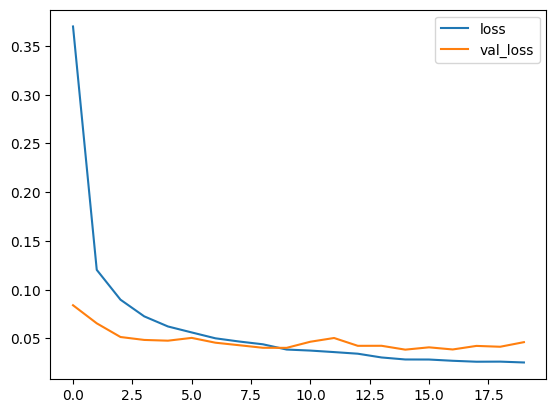

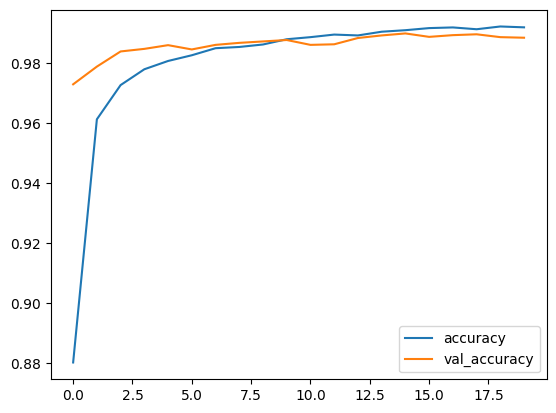

In [27]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

# 6. TEST PREPROCESSING + Model Prediction

In [28]:
test1 = test.values.reshape(-1,28,28,1)/255

In [29]:
cnn_preds = model.predict(test1)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [30]:
predicted_labels = np.argmax(cnn_preds,axis=1)
predicted_labels.reshape(28000,1).shape

(28000, 1)

# 7. SUBMISSION

In [31]:
ids = np.arange(1,28001)
ids.reshape(28000,1)

array([[    1],
       [    2],
       [    3],
       ...,
       [27998],
       [27999],
       [28000]])

In [32]:
submission_df = pd.DataFrame({
    'ImageId':ids,
    'Label':predicted_labels
})

In [33]:
submission_df.to_csv('submission.csv',index=False)

In [ ]:
model.save('digit_recognizer.h5')